# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Pipeline classif infox supervisé dataset labels

---

# Observations et environnement
---

## Environnement

In [1]:
random_state = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

## Données

In [4]:
filename = 'data/prod/230510-OIDS-Label.csv'

In [5]:
df_label = pd.read_csv(filename)
df_label['paragraphs'] = df_label['paragraphs'].apply(ast.literal_eval)
df_label['abstract'].fillna('',inplace=True)

In [6]:
df_label['infox'].isna().sum()

36

In [7]:
df_label = df_label[df_label['infox'].notna()]

## Prédicteur

In [8]:
import patat.util.file
#predfile = 'data/tmp/230425-PredInfox.pickle'
predfile = 'data/prod/230510-LogRegInfox.pickle'
predictor = patat.util.file.pickle_load(predfile)

# Experience
---

In [10]:
text = df_label.sample(1,random_state=random_state).iloc[0]['text']

In [11]:
print(text)

Atteint de sclérose en plaques, Julien Védani tente de gravir le Kilimandjaro
Julien Védani croit en son rêve. Aidé par la technologie mais aussi ses amis, l'homme, atteint de sclérose en plaques, veut relever un défi de taille : gravir le Kilimandjaro.
Il dispose d'une volonté à toute épreuve. Atteint d'une sclérose en plaques, Julien Védani veut tout de même relever un objectif important. D'abord aidé par une technologie, c'est ensuite en s'appuyant sur une perche tenue par ses amis ainsi que sa béquille et la force de ses jambes qu'il tente de gravir le Kilimandjaro. Au fur et à mesure, l'équilibre devient de plus en plus précaire. Après quatre heures d'efforts, au bord de l'épuisement, il arrive finalement au camp.
Le lendemain, une nouvelle journée d'ascension démarre pour Julien Védani et son équipe. Une fois le plateau à 3 300 mètres de haut atteint, une pause déjeuner s'impose. L'infirmière Vanessa Moralès teste le grimpeur sur sa réaction à l'altitude. Mais malgré l'aide des a

In [12]:
import numpy as np

In [13]:
df_label['predict_infox']=np.round(predictor.predict_proba(df_label['text'])[:,1],3)

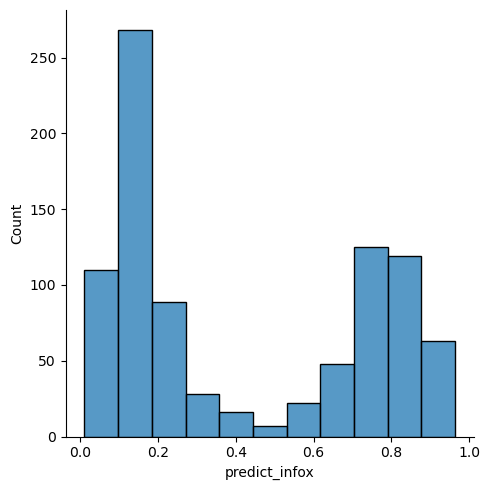

In [14]:
sns.displot(df_label,x='predict_infox')

In [15]:
df_label['predict_parags']=df_label['paragraphs'].progress_apply(lambda ps: predictor.predict_proba(ps)[:,1])


  0%|          | 0/895 [00:00<?, ?it/s]

In [16]:

def print_parags(index):
    print(df_label['title'][index])
    print(f'Infox level : {df_label["predict_infox"][index]}\n')
    parags = df_label['paragraphs'][index]
    for i in range(0,len(parags)):
        proba = df_label['predict_parags'][index][i]
        if proba < .3:
            print (colored(parags[i], 'green'))
        elif proba > .7:
            print (colored(parags[i], 'red'))
        else:
            print(parags[i])
        

In [17]:
print_parags(10)

Révélé : des documents montrent comment le DHS complote pour contrôler la « désinformation » en ligne
Infox level : 0.865

Un grand nombre de documents et de communications du ministère de la Sécurité intérieure (DHS), obtenus par le biais de fuites, de demandes de liberté d’information (FOIA), de rapports publics et du procès en cours sur la collusion entre Biden et Big Tech en matière de censure, ont jeté un nouvel éclairage sur les efforts continus du DHS pour contrôler la « désinformation » en ligne.
Les documents, qui ont été obtenus par The Intercept, révèlent l’existence d’un portail Facebook que le DHS et d’autres agences gouvernementales peuvent utiliser pour signaler des contenus au géant de la technologie, montrent des preuves que le DHS signale des contenus à Twitter, documentent les réunions bihebdomadaires de « désinformation liée aux élections » entre les géants de la technologie et le DHS, et plus encore.
Un document montre que Facebook a créé un « système de demande de

NameError: name 'colored' is not defined

## Prédictions sur le Corpus

### Chargement Corpus

In [ ]:
df_label.reset_index(inplace=True)

In [ ]:
import patat.db.article_db

In [ ]:
df_corpus = patat.db.article_db.ArticleDb().df().copy()

In [ ]:
df_corpus

### Calcul des textes

In [ ]:
import patat.imp.parser

In [ ]:
parser = patat.imp.parser.Parser()

In [ ]:
df_corpus['text']=df_corpus.progress_apply(lambda row: parser.text_from_data(row['title'],row['abstract'],row['paragraphs']),axis=1)




### Prédiction infox

In [ ]:
df_corpus['predict_infox']=np.round(predictor.predict_proba(df_corpus['text'])[:,1],3)

In [ ]:
df_corpus['predict_parags']=df_corpus['paragraphs'].progress_apply(lambda ps: predictor.predict_proba(ps)[:,1])

### Debug Patat

In [ ]:
importlib.reload(patat.db.article_db)

article_db = patat.db.article_db.ArticleDb('data/prod/230510-OIDS-Corpus.csv')

In [ ]:
article_db.get_corpus_data()

# Sauvegarde des résultats
---

In [ ]:
df_corpus['predict_parags_json']=df_corpus['predict_parags'].apply(lambda x: json.dumps(list(x)))

In [ ]:
df_corpus = df_corpus.drop(columns=['text'])

In [ ]:
corpus_filename = 'data/prod/230510-OIDS-Corpus.csv'

In [ ]:
df_corpus.to_csv(corpus_filename)

# Conclusions
---

# Bricolages
---

In [ ]:
round(df_corpus['predict_infox'][0],3)

In [ ]:
df_corpus